<h4>Transformer</h4>

<h5>Imports</h5>

In [16]:
from urllib.parse import urlparse, parse_qs, urlencode, urlunparse, unquote_plus
import tensorflow as tf
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Input, Dropout
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
import jsonlines
import os
import json
import pickle
from sklearn.metrics import f1_score, accuracy_score, precision_score
from typing import Callable
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
from tensorflow.python.profiler import profiler_v2 as profiler
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, precision_recall_curve

import matplotlib.pyplot as plt

In [2]:
#loda all payloads from txt files in dataset folder (where each payload is one line)
def load_payloads(dataset_path: str) -> list:
    payloads = []
    for filename in os.listdir(dataset_path):
        with open(dataset_path + filename, 'r') as f:
            payloads.extend(f.readlines())
    return payloads

In [3]:
file_names=['malicious','normal']
for name in file_names:
    data=[]
    with jsonlines.open('dataset/'+name+'.txt') as reader:
        for line in reader:
            if line['request']['method'] == 'POST':
                data.append({'request':{'method':'POST', 'uri':line['request']['uri'], 'body':line['request']['body'],'headers':line['request']['headers']},'metadata':line['metdata']})
            else:
                data.append({'request':{'method':'GET', 'uri':line['request']['uri'], 'headers':line['request']['headers']},'metadata':line['metdata']})
    with jsonlines.open('dataset/'+name+'_clean.txt', mode='w') as writer:
        writer.write_all(data)

<h4>Load and create datasets</h4>

In [4]:
from collections import Counter


file_names = ['dataset/malicious_clean.txt' ,'dataset/normal_clean.txt']
data={}
for file in file_names:
    data[file]=[]
    with jsonlines.open(file) as reader:
        for line in reader:
            if line['request']['method'] == 'POST':
                data[file].append('POST'+' '+line['request']['uri']+' '+line['request']['body']+' '+json.dumps(line['request']['headers']))
            else:
                data[file].append('GET'+' '+line['request']['uri']+' '+json.dumps(line['request']['headers']))

payloads = shuffle(load_payloads('dataset/payloads/'),random_state=0)[:2500]     
                
normal = data[file_names[1]]
malicious = data[file_names[0]]
normal_part1 = normal[180000:]
normal_part2 = normal[:180000]

train_examples = normal_part2
test_examples = normal_part1+malicious
train_labels = [0] * len(train_examples)
test_labels = [0]* len(normal_part1)
test_labels.extend([1] * len(malicious))

payload_iterator={}
payload_iterator[0] = 0
def get_next_payload():
    payload_iterator[0] = (payload_iterator[0] + 1) % len(payloads)
    return payloads[payload_iterator[0]]

#create synthetic malicious data by adding payloads to normal data (PAYLOAD SHOULD BE injected at a space character )
tmp = normal_part1.copy()
np.random.shuffle(payloads)
synthetic_malicious = []
for i in range(len(tmp)):
    payload = get_next_payload()
    tmp[i] = tmp[i].split(' ') 
    tmp[i].insert(np.random.randint(0,len(tmp[i])), payload)
    tmp[i] = ' '.join(tmp[i])
    synthetic_malicious.append(tmp[i])


# add shuffled malicious data to train set
#malicious_shuffled = malicious.copy()  
#np.random.shuffle(malicious_shuffled)
#train_examples.extend(malicious_shuffled[:50000])
#train_labels.extend([1] * len(malicious_shuffled[:50000]))

train_examples.extend(synthetic_malicious)
train_labels.extend([1] * len(synthetic_malicious))

dataset_train = tf.data.Dataset.from_tensor_slices((list(map(lambda x: unquote_plus(x),train_examples)), train_labels))
dataset_test = tf.data.Dataset.from_tensor_slices((list(map(lambda x: unquote_plus(x),test_examples)), test_labels))

#shuflee datasets with given radnom seed
dataset_train = dataset_train.shuffle(400000, seed=42, reshuffle_each_iteration=False)
dataset_test = dataset_test.shuffle(400000, seed=42, reshuffle_each_iteration=False)

def preprocess_text(text, label):
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, "[a-zA-Z]+", "a")
    text = tf.strings.regex_replace(text, "[0-9]+", "n")
    text = tf.strings.regex_replace(text, "(a|n){2,}", "x")
    text = tf.strings.regex_replace(text, '[^\x00-\x7F]+', '')
    text = tf.strings.regex_replace(text, '(.)',  r'\1 ')
    return text, label

def preprocess_text_substitution(text, label):
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, "[a-zA-Z]+", "a")
    text = tf.strings.regex_replace(text, "[0-9]+", "n")
    text = tf.strings.regex_replace(text, "(a|n){2,}", "x")
    text = tf.strings.regex_replace(text, '[^\x00-\x7F]+', '')
    punctuation = "=?/(){}[]<>"
    for p in punctuation:
        text = tf.strings.regex_replace(text, "\\" + p, " "+p+" ")
    return text, label

 
# Map the preprocess function to the dataset
train = dataset_train.map(preprocess_text)
test = dataset_test.map(preprocess_text)

train_sub = dataset_train.map(preprocess_text_substitution)
test_sub = dataset_test.map(preprocess_text_substitution)

for text, label in train_sub.take(1):
    print(text.numpy(), label.numpy())

for text, label in train.take(1):
    print(text.numpy(), label.numpy())




2023-06-06 14:17:27.944181: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-06 14:17:27.987269: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-06 14:17:27.987315: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-06 14:17:27.989402: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-06 14:17:27.989452: I tensorflow/compile

b'a  / a / a-a  { "a-a": "a-a", "a": "a / a,a / a a,a / a;a = n.n,a / a,a / a,* / *;a = n.n", "a-a": "a", "a-a": "a / n.n  ( a; a a a a n_n_n )  a / n.n  ( a, a a )  a / n.n.n.n a / n.n", "a": "a = x; a = x" } ' 0
b'a   / a / a - a   { " a - a " :   " a - a " ,   " a " :   " a / a , a / a   a , a / a ; a = n . n , a / a , a / a , * / * ; a = n . n " ,   " a - a " :   " a " ,   " a - a " :   " a / n . n   ( a ;   a   a   a   a   n _ n _ n )   a / n . n   ( a ,   a   a )   a / n . n . n . n   a / n . n " ,   " a " :   " a = x ;   a = x " } ' 0


<h4>Save and load vectorization from disk</h4>

In [5]:
#pickle.dump({'config': vectorization.get_config(),'weights': vectorization.get_weights()}, open("vectorization.pkl", "wb"))

#pickle.dump({'config': vectorization_sub.get_config(), 'weights': vectorization_sub.get_weights()}, open("vectorization_sub.pkl", "wb"))


from_disk = pickle.load(open("vectorization.pkl", "rb"))
vectorization = TextVectorization.from_config(from_disk['config'])
# You have to call `adapt` with some dummy data (BUG in Keras)
vectorization.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
vectorization.set_weights(from_disk['weights'])

from_disk_sub = pickle.load(open("vectorization_sub.pkl", "rb"))
vectorization_sub = TextVectorization.from_config(from_disk_sub['config'])
# You have to call `adapt` with some dummy data (BUG in Keras)
vectorization_sub.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
vectorization_sub.set_weights(from_disk_sub['weights'])

2023-06-06 14:17:30.320866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-06-06 14:17:30.425526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


<h4>CNN</h4>

In [6]:
embedding_layer_sub = tf.keras.layers.Embedding(1000, 4)
embedding_layer = tf.keras.layers.Embedding(5000, 4)
flatten_layer = tf.keras.layers.Flatten()



def sub_processing(text, label):
    return  vectorization_sub(text), label

def processing(text, label):
    return  vectorization(text), label

train_auto_sub = train_sub.map(sub_processing)
train_auto = train.map(processing)

train_auto = train_auto.batch(32)
train_auto_sub = train_auto_sub.batch(32)


class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), 
             Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1+ ffn_output)
    
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    

# Define the autoencoder model
input_layer = tf.keras.layers.Input(shape=(256,))
embedding_layer = TokenAndPositionEmbedding(256, 1000, 32)
mod = embedding_layer(input_layer)
transformer_block = TransformerBlock(32, 4, 32)
mod = transformer_block(mod)
mod = GlobalAveragePooling1D()(mod)
mod =  tf.keras.layers.Dense(128, activation='relu')(mod)
mod =  tf.keras.layers.Dense(64, activation='relu')(mod)
mod =  tf.keras.layers.Dense(1, activation='sigmoid')(mod)

trans = tf.keras.models.Model(input_layer, mod)

input_layer_sub = tf.keras.layers.Input(shape=(128,))
embedding_layer_sub = TokenAndPositionEmbedding(128, 1000, 32)
mod_sub = embedding_layer_sub(input_layer_sub)
transformer_block_sub = TransformerBlock(32, 4, 32)
mod_sub = transformer_block_sub(mod_sub)
mod_sub = GlobalAveragePooling1D()(mod_sub)
mod_sub =  tf.keras.layers.Dense(128, activation='relu')(mod_sub)
mod_sub =  tf.keras.layers.Dense(64, activation='relu')(mod_sub)
mod_sub =  tf.keras.layers.Dense(1, activation='sigmoid')(mod_sub)

trans_sub = tf.keras.models.Model(input_layer_sub, mod_sub)


# Compile and train the model
trans.compile(optimizer='adam',  loss=losses.BinaryCrossentropy())
trans_sub.compile(optimizer='adam',  loss=losses.BinaryCrossentropy())

import time
start_time = time.time()
trans.fit(train_auto, epochs=10)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")
start_time = time.time()
trans_sub.fit(train_auto_sub, epochs=10)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Epoch 1/10


2023-06-06 14:17:30.953682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype int64
	 [[{{node Placeholder/_10}}]]
2023-06-06 14:17:33.170266: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-06 14:17:33.178610: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fb058644d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-06 14:17:33.178645: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-06-06 14:17:33.182783: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, se

6613/6613 [==============================] - 93s 13ms/step - loss: 0.1069
Epoch 2/10
6613/6613 [==============================] - 92s 14ms/step - loss: 0.0689
Epoch 3/10
6613/6613 [==============================] - 91s 14ms/step - loss: 0.0622
Epoch 4/10
6613/6613 [==============================] - 91s 14ms/step - loss: 0.0572
Epoch 5/10
6613/6613 [==============================] - 90s 14ms/step - loss: 0.0536
Epoch 6/10
6613/6613 [==============================] - 91s 14ms/step - loss: 0.0510
Epoch 7/10
6613/6613 [==============================] - 91s 14ms/step - loss: 0.0484
Epoch 8/10
6613/6613 [==============================] - 90s 14ms/step - loss: 0.0461
Epoch 9/10
6613/6613 [==============================] - 92s 14ms/step - loss: 0.0443
Epoch 10/10
6613/6613 [==============================] - 90s 14ms/step - loss: 0.0429
Elapsed time: 911.3689305782318 seconds
Epoch 1/10


2023-06-06 14:32:42.320046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype resource
	 [[{{node Placeholder/_9}}]]


6613/6613 [==============================] - 82s 12ms/step - loss: 0.0467
Epoch 2/10
6613/6613 [==============================] - 65s 10ms/step - loss: 0.0279
Epoch 3/10
6613/6613 [==============================] - 64s 10ms/step - loss: 0.0205
Epoch 4/10
6613/6613 [==============================] - 65s 10ms/step - loss: 0.0159
Epoch 5/10
6613/6613 [==============================] - 64s 10ms/step - loss: 0.0127
Epoch 6/10
6613/6613 [==============================] - 64s 10ms/step - loss: 0.0111
Epoch 7/10
6613/6613 [==============================] - 64s 10ms/step - loss: 0.0094
Epoch 8/10
6613/6613 [==============================] - 68s 10ms/step - loss: 0.0091
Epoch 9/10
6613/6613 [==============================] - 68s 10ms/step - loss: 0.0077
Epoch 10/10
6613/6613 [==============================] - 68s 10ms/step - loss: 0.0073
Elapsed time: 672.1564946174622 seconds


In [8]:

trans.save('trans/my_model')
trans_sub.save('trans_sub/my_model')


trans = tf.keras.models.load_model('trans/my_model')
trans_sub = tf.keras.models.load_model('trans_sub/my_model')


2023-06-06 14:47:14.639126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_input' with dtype float and shape [?,?,32]
	 [[{{node dense_input}}]]
2023-06-06 14:47:14.653528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_input' with dtype float and shape [?,?,32]
	 [[{{node dense_input}}]]
2023-06-06 14:47:14.659337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,32]
	 [[{{node inpu

INFO:tensorflow:Assets written to: trans/my_model/assets


INFO:tensorflow:Assets written to: trans/my_model/assets
2023-06-06 14:47:15.720501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_5_input' with dtype float and shape [?,?,32]
	 [[{{node dense_5_input}}]]
2023-06-06 14:47:15.735886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_5_input' with dtype float and shape [?,?,32]
	 [[{{node dense_5_input}}]]
2023-06-06 14:47:15.742720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder te

INFO:tensorflow:Assets written to: trans_sub/my_model/assets


INFO:tensorflow:Assets written to: trans_sub/my_model/assets


In [9]:


test_auto_sub = test_sub.map(sub_processing)
test_auto_sub = test_auto_sub.batch(32)
test_auto = test.map(processing)
test_auto = test_auto.batch(32)
reconsturctions =  trans.predict(test_auto)
reconsturctions_sub =  trans_sub.predict(test_auto_sub)


2023-06-06 14:47:17.312207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype string
	 [[{{node Placeholder/_11}}]]
2023-06-06 14:47:17.404600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'x' with dtype float and shape [?,?]
	 [[{{node x}}]]


3685/3685 [==============================] - 24s 6ms/step


2023-06-06 14:47:42.502453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [117899]
	 [[{{node Placeholder/_0}}]]
2023-06-06 14:47:42.620294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'x' with dtype float and shape [?,?]
	 [[{{node x}}]]


3685/3685 [==============================] - 24s 6ms/step


In [10]:
pred = list(map(lambda x: 0 if x[0]<0.5 else 1, list(reconsturctions)))
pred_sub = list(map(lambda x: 0 if x[0]<0.5 else 1, list(reconsturctions_sub)))

In [11]:
actual =test_auto.map(lambda x,y:y)
actual = np.concatenate(list(actual.as_numpy_iterator()))

2023-06-06 14:48:07.623258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [117899]
	 [[{{node Placeholder/_0}}]]


In [12]:
print("Metrics")
print("f1: ", f1_score(actual,pred))
print("acc: ", accuracy_score(actual,pred))
print("prec: ", precision_score(actual,pred))

Metrics
f1:  0.9158767252883574
acc:  0.8861143860422904
prec:  0.9969991270187691


In [13]:
print("Metrics sub")
print("f1: ", f1_score(actual,pred_sub))
print("acc: ", accuracy_score(actual,pred_sub))
print("prec: ", precision_score(actual,pred_sub))

Metrics sub
f1:  0.9407159179322555
acc:  0.9179212715968753
prec:  0.9979852337128893


Accuracy: 0.9179212715968753
Precision: 0.9979852337128893
Recall: 0.8896626843879999
F1 Score: 0.9407159179322555
MCC: 0.8230005828802239


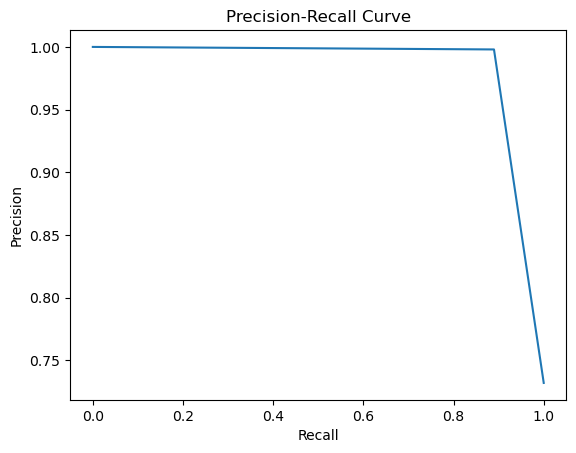

In [19]:
y_pred = pred_sub
y_test = actual
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("MCC:", mcc)

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, reconstructions)

# Plot precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()